In [1]:
import networkx as nx
from networkx.generators.random_graphs import _random_subset
import sympy as sp
from sympy import symbols 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds
from sympy.utilities.lambdify import lambdify


import copy
import time
import random as rd

graph = "CO2.adjlist"
# graph = "CO.adjlist"

eigen = "CO2-pS.txt"
# eigen = "CO-pS.txt"

## Creazione del grafo

In [2]:
G = nx.read_adjlist(graph)

nodes = sorted([int(n) for n in G.nodes])

In [3]:
N = len(G.nodes)

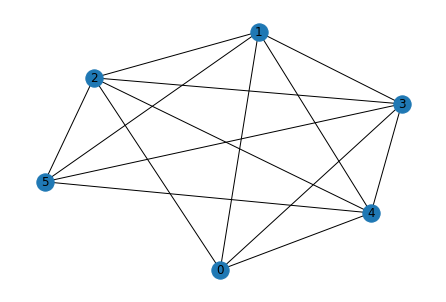

In [4]:
nx.draw(G, with_labels=True)
plt.show()
# plt.savefig('./Figs/NetworkBeforeRemove.jpeg')

In [5]:
adjacency = list(G.adjacency())

In [6]:
A = []
for a, b in adjacency :
    A += [[0]*len(adjacency)]

for a, b in adjacency :
    a = int(a)
    for c in b :
        c = int(c)
        A[a][c] = 1

In [7]:
adjacency = list(G.adjacency())
A1 = []
for a, b in adjacency :
    A1 += [[0]*len(adjacency)]

for a, b in adjacency :
    a = int(a)
    for c in b :
        c = int(c)
        A1[a][c] = 1
        
P1 = []
for a, b in adjacency :
    P1 += [[0]*len(adjacency)]
    
for a, b in adjacency :
    a = int(a)
    for c in b: 
        c = int(c)
        P1[a][c] = 1./G.degree[str(a)]

matrixP1 = np.array(P1)
autovaloriP1, autovettoriP1 = np.linalg.eig(np.transpose(matrixP1))
autovettoriP1 = np.transpose(autovettoriP1)

diff = [np.abs(autovaloriP1[i] - 1) for i in range(N)]
minDiff = min(diff)
for i in range(N):
    if np.abs(autovaloriP1[i] - 1) == minDiff:
        pS1 = autovettoriP1[i]
        print("Eigenvector found")
        break

if pS1[0] < 0:
    pS1 = -pS1

print('Autovalori di P1:', autovaloriP1, '\n')

matrixL1 = np.identity(N) - matrixP1

autovaloriL1, autovettoriL1 = np.linalg.eig(np.transpose(matrixL1))
autovettoriL1 = np.transpose(autovettoriL1)

diff = [np.abs(autovaloriL1[i]) for i in range(N)]
minDiff = min(diff)
for i in range(N):
    if np.abs(autovaloriL1[i]) == minDiff:
        pS1_L = autovettoriL1[i]
        print("Eigenvector found")
        break

if pS1_L[0] < 0:
    pS1_L = -pS1_L

print('Autovalori di L1:', autovaloriL1, '\n')
print('Autovettore stazionario:', pS1_L, '\n')

i = 13
print(np.round(pS1, i) == np.round(pS1_L, i))

pS1  = np.round(pS1.real, i)

Eigenvector found
Autovalori di P1: [ 1.00000000e+00+0.00000000e+00j -4.00000000e-01+0.00000000e+00j
  1.23455964e-17+0.00000000e+00j -2.00000000e-01+0.00000000e+00j
 -2.00000000e-01+1.20185168e-17j -2.00000000e-01-1.20185168e-17j] 

Eigenvector found
Autovalori di L1: [1.11022302e-16 1.00000000e+00 1.40000000e+00 1.20000000e+00
 1.20000000e+00 1.20000000e+00] 

Autovettore stazionario: [0.34815531 0.43519414 0.43519414 0.43519414 0.43519414 0.34815531] 

[ True  True  True  True  True  True]


Dinamica prima della rottura di un link

In [8]:
seed = np.random.RandomState()
def dynamic_evolution(G, history = []):
    evolution = [0] * len(G.nodes)
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neighbours = list(G[n])
            new_node = _random_subset(neighbours, 1, seed).pop()
            evolution[int(new_node)] += 1
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[int(n)]
    history += [evolution]

In [9]:
walker_per_node = int(5e3)

In [10]:
long_history = [[]]
for h in range(len(long_history)):
    long_history[h] = [[walker_per_node] * len(G.nodes)]

In [11]:
time_steps = int(5e1)

In [12]:
t0 = time.time()

for h in range(len(long_history)):
    for n in G.nodes:
        G.nodes[n]['N_i'] = walker_per_node
    
    for t in range(time_steps):
        dynamic_evolution(G, long_history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 22.992926120758057 seconds


## Rimozione di un link

In [13]:
index = []
for i in range(N):
    for j in range(i+1, N):
        if A[i][j] == 1:
            index += [(i,j)]

removed_link = [0, 4]
# removed_link = index[rd.randint(0, len(index)-1)]
links = len(index) - 1

G.remove_edge(str(removed_link[0]), str(removed_link[1]))

In [14]:
for i in range(N):
    if A[i][i] == 1:
        links += 1

In [15]:
print("It was removed the link between node", removed_link[0], "and node", removed_link[1])

It was removed the link between node 0 and node 4


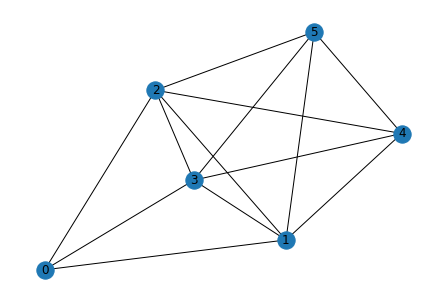

In [16]:
nx.draw(G, with_labels=True)
plt.show()
# plt.savefig('./Figs/NetworkAfterRemove.png')

In [17]:
A[removed_link[0]][removed_link[1]] = 0
A[removed_link[1]][removed_link[0]] = 0

Calcolare autovalori e autovettori del nuovo grafo dopo la rottura di un link

In [18]:
adjacency = list(G.adjacency())
A2 = []
for a, b in adjacency :
    A2 += [[0]*len(adjacency)]

for a, b in adjacency :
    a = int(a)
    for c in b :
        c = int(c)
        A2[a][c] = 1
        
P2 = []
for a, b in adjacency :
    P2 += [[0]*len(adjacency)]
    
for a, b in adjacency :
    a = int(a)
    for c in b: 
        c = int(c)
        P2[a][c] = 1./G.degree[str(a)]

matrixP2 = np.array(P2)
autovaloriP2, autovettoriP2 = np.linalg.eig(np.transpose(matrixP2))
autovettoriP2 = np.transpose(autovettoriP2)

diff = [np.abs(autovaloriP2[i] - 1) for i in range(N)]
minDiff = min(diff)
for i in range(N):
    if np.abs(autovaloriP2[i] - 1) == minDiff:
        pS2 = autovettoriP2[i]
        print("Eigenvector found")
        break

if pS2[0] < 0:
    pS2 = -pS2

print('Autovalori di P:', autovaloriP2)

matrixL2 = np.identity(N) - matrixP2

autovaloriL2, autovettoriL2 = np.linalg.eig(np.transpose(matrixL2))
autovettoriL2 = np.transpose(autovettoriL2)

diff = [np.abs(autovaloriL2[i]) for i in range(N)]
minDiff = min(diff)
for i in range(N):
    if np.abs(autovaloriL2[i]) == minDiff:
        pS2_L = autovettoriL2[i]
        print("Eigenvector found")
        break

if pS2_L[0] < 0:
    pS2_L = -pS2_L

print('Autovalori di L:', autovaloriL2)

Eigenvector found
Autovalori di P: [ 1.          0.10894542 -0.45894542 -0.2        -0.2        -0.25      ]
Eigenvector found
Autovalori di L: [0.         0.89105458 1.45894542 1.2        1.2        1.25      ]


In [19]:
i = 13
print(np.round(pS2, i) == np.round(pS2_L, i))

pS2  = np.round(pS2.real, i)

[ True  True  True  True  True  True]


Dinamica dopo la rottura di un link

In [20]:
t0 = time.time()

for h in range(len(long_history)):    
    for t in range(time_steps):
        dynamic_evolution(G, long_history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 21.853031873703003 seconds


## Otimmizzazione dei pesi

In [21]:
W = symbols(f'w:{links}')
print("There are", links, "indipendent weights")

There are 13 indipendent weights


In [22]:
count = 0
x0 = []
P = copy.deepcopy(A)
for i in range(N):
    for j in range(i, N):
        if P[i][j] == 1:
            P[i][j] = W[count]
            P[j][i] = W[count]
            count += 1
            x0 += [P2[i][j]]

2* L'autovettore stazionario non coincide

In [23]:
with open(eigen, "r") as file:
    pS = file.read()
    pS = pS.split("\n")
    
pS = [float(i) for i in pS]
pS = np.round(pS, 5)

In [24]:
WpS = [pS[i]*sum(P[i]) for i in range(N)]

In [25]:
e = (np.dot(P, pS) - WpS)
E = e[0]**2
for i in range(1, len(e)):
    E += e[i]**2

1* Aggiungere la normalizzazione dei pesi alla funzione di costo fa ottenere molti autovettori vicini a 1 e l'autovettore stazionario non coincide con il valore atteso.

In [26]:
E

0.0075742209*w12**2 + 0.0075742209*(-w0 - w6)**2 + 0.0075742209*(-w1 - w9)**2 + 0.0075742209*(-w11 - w2)**2 + 0.0075742209*(w0 + w1 + w2)**2 + 0.0075742209*(w11 + w12 + w6 + w9)**2

In [27]:
cost = lambdify(W, E)

def cost_function(x):
    return cost(*tuple(x))

In [28]:
t0 = time.time()

result = minimize(cost_function, x0, 
                  bounds = Bounds(0.1, 0.5),
                  method = 'SLSQP',
                  tol = 1e-12,
                  options = {})
solution = result.x

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 0.00801229476928711 seconds


In [29]:
count = 0
P_new = copy.deepcopy(A)
for i in range(N):
    for j in range(i, N):
        if P_new[i][j] == 1:
            P_new[i][j] = solution[count]
            P_new[j][i] = solution[count]
            count += 1

In [30]:
norm = max([sum(P_new[i]) for i in range(len(P_new))])
for i in range(len(P_new)):
    P_new[i][i] += norm - sum(P_new[i])

In [48]:
P_new

[[0.4999999999999999, 0.1, 0.1, 0.10000000000000002, 0, 0],
 [0.1, 0.0, 0.2, 0.2, 0.2, 0.10000000000000002],
 [0.1, 0.2, 0.0, 0.2, 0.2, 0.10000000000000002],
 [0.10000000000000002, 0.2, 0.2, 0.0, 0.2, 0.10000000000000002],
 [0, 0.2, 0.2, 0.2, 0.09999999999999987, 0.1],
 [0,
  0.10000000000000002,
  0.10000000000000002,
  0.10000000000000002,
  0.1,
  0.3999999999999999]]

2* l'autovettore stazionario non coincide con quello atteso

Calcolo dei nuovi autovalori e autovettori dopo l'ottimizzazione

In [31]:
matrixP = np.array(P_new)

Delta = np.identity(N)
for i in range(N):
    Delta[i][i] = norm

matrixL = Delta - matrixP

autovaloriL, autovettoriL = np.linalg.eig(np.transpose(matrixL))
autovettoriL = np.transpose(autovettoriL)

diff = [np.abs(autovaloriL[i]) for i in range(N)]
minDiff = min(diff)
for i in range(N):
    if np.abs(autovaloriL[i]) == minDiff:
        pS_new = autovettoriL[i]
        print("Eigenvector found")
        break

if pS_new[0] < 0:
    pS_new = -pS_new

print('Autovalori di L:', autovaloriL, '\n')
print('Autovettore stazionario:', pS_new, '\n')

pS_new = pS_new.real

Eigenvector found
Autovalori di L: [-1.11022302e-16  3.19645750e-01  5.37566362e-01  9.42787887e-01
  1.00000000e+00  1.00000000e+00] 

Autovettore stazionario: [0.40824829 0.40824829 0.40824829 0.40824829 0.40824829 0.40824829] 



Dinamica dopo l'ottimizzazione dei pesi

In [32]:
seed = np.random.RandomState()
def dynamic_evolution_after(G, P_new, history = []):
    evolution = [0]*N
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neightbours = []
            n = int(n)
            for ind in range(len(P_new)):
                if P_new[n][ind] != 0:
                    if len(neightbours) != 0:
                        neightbours += [[ind, P_new[n][ind] + neightbours[-1][1]]]
                    else:
                        neightbours = [[ind, P_new[n][ind]]]
            s = sum(P_new[n])
            prob = rd.uniform(0., s)

            for neigh, p in neightbours:
                if prob <= p:
                    evolution[neigh] += 1
                    break
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[int(n)]
    history += [evolution]

In [33]:
history = [[], [], []]
for h in range(len(history)):
    history[h] = [[walker_per_node] * len(G.nodes)]

In [34]:
t0 = time.time()

for h in range(len(long_history)):
    h = int(h)
    for t in range(time_steps):
        dynamic_evolution_after(G, P_new, long_history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 6.15049147605896 seconds


In [35]:
time_steps2 = int(1e2)

In [36]:
t0 = time.time()

for h in range(len(history)):
    h = int(h)
    for n in G.nodes:
        G.nodes[n]['N_i'] = walker_per_node 
    
    for t in range(time_steps2):
        dynamic_evolution_after(G, P_new, history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 36.681602239608765 seconds


## Rappresentazione dei risultati

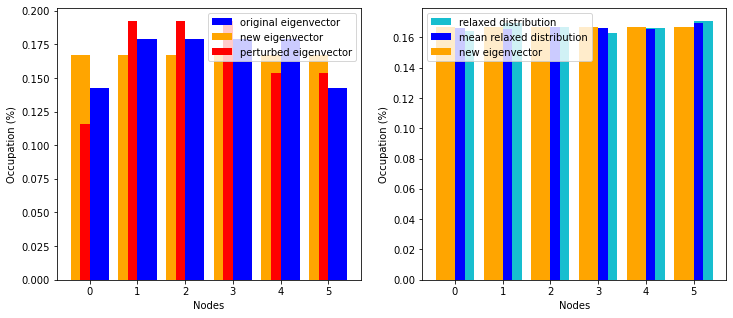

Solution found minimizing 6 equation in 13 variables


In [37]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(2*N, 5))

pSNorm = [h/sum(pS) for h in pS]
pS2Norm = [h/sum(pS2) for h in pS2]
pSNorm_new = [h/sum(abs(pS_new)) for h in pS_new]

ax[0].bar(nodes, pSNorm, width=0.4, align='edge', color='blue', label="original eigenvector")
ax[0].bar(nodes, pSNorm_new, width=-0.4, align='edge', color='orange', label="new eigenvector")
ax[0].bar(nodes, pS2Norm, width=-0.2, align='edge', color='red', label="perturbed eigenvector")

hMean = [[(h1+h2+h3)/walker_per_node/N/3 
          for h1, h2, h3 in zip(history[0][i], history[1][i], history[2][i])] 
         for i in range(len(history[0]))]

ax[1].bar(nodes, [h/sum(history[0][-1]) for h in history[0][-1]], width=0.4, 
          align='edge', color='tab:cyan', label='relaxed distribution')
ax[1].bar(nodes, hMean[-1], width=0.2, align='edge', color='blue', label='mean relaxed distribution')
ax[1].bar(nodes, pSNorm_new, width=-0.4, align='edge', color='orange', label="new eigenvector")

for i in [0,1]:
    ax[i].legend()
    ax[i].set_xlabel("Nodes")
    ax[i].set_ylabel("Occupation (%)")
    ax[i].set_xticks(np.arange(0, N, 1))
#     ax[i].grid(True)

plt.show()
# plt.savefig('Eigenvectors.png')

print(f"Solution found minimizing {N} equation in {links} variables")

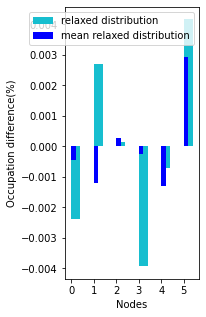

1.2021513262438205e-07


In [38]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(0.4*N, 5))

ax.bar(nodes, [h/sum(history[0][-1]) - k for h, k in zip(history[0][-1], pSNorm_new)], width=0.4, 
       align='edge', color='tab:cyan', label='relaxed distribution')
ax.bar(nodes, [h - k for h, k in zip(hMean[-1], pSNorm_new)],
       width=0.2, align='edge', color='blue', label='mean relaxed distribution')

ax.legend()
ax.set_xlabel("Nodes")
ax.set_ylabel("Occupation difference(%)")
ax.set_xticks(np.arange(0, N, 1))
# ax.grid(True)

plt.show()

print(sum([(h - k)**2 for h, k in zip(hMean[-1], pSNorm_new)])/len(history[0]))

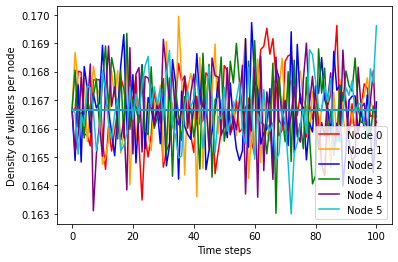

In [39]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
node = [0, 1, 2, 3, 4, 5]
color = ['red', 'orange', 'blue', 'green', 'purple', 'tab:cyan']

time_range = hMean
index = np.arange(0, len(time_range), 1)

col = 0
for i in node:
    ax.plot(index, [time_range[ind][i] for ind in index], label = f"Node {i}", color = color[col])
    ax.plot(index, [pSNorm_new[i]]*len(index), 
#             label = f"Expected value for node {i}", 
            color = color[col])
    col += 1
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Density of walkers per node")
ax.legend()

plt.show()
# plt.savefig('Dinamic.png')

## Evoluzione dinamica totale

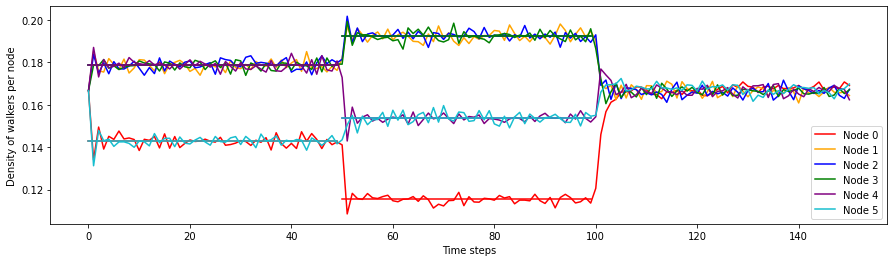

In [40]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15, 4))
# node = nodes
# color = ['red', 'orange', 'blue', 'green']

time_range = long_history[0]
index = np.arange(0, len(time_range), 1)
index1 = np.arange(0, time_steps, 1)
index2 = np.arange(time_steps, 2*time_steps, 1)
index3 = np.arange(2*time_steps, 3*time_steps, 1)

col = 0
for i in node:
    ax.plot(index, [time_range[ind][i]/walker_per_node/N for ind in index], label = f"Node {i}", color = color[col])
    ax.plot(index1, [pSNorm[i]]*len(index1), 
#             label = f"Expected value for node {i}", 
            color = color[col])
    ax.plot(index2, [pS2Norm[i]]*len(index2), 
#             label = f"Perturbed value for node {i}", 
            color = color[col])
#     ax.plot(index3, [pSNorm_new[i]]*len(index3), 
#             label = f"Perturbed value for node {i}", 
#             color = color[col])
    
#     index2 = np.arange(2*time_steps, 3*time_steps, 5)
#     ax.plot(index2, [time_range[ind][i]/walker_per_node/N for ind in index2], label = f"Node {i}", color = color[col])

    col += 1
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Density of walkers per node")
ax.legend()

plt.show()
# plt.savefig('CompleteDinamic.png')

In [41]:
result

     fun: 0.0028782039420000008
     jac: array([0.00757422, 0.00757422, 0.00757422, 0.        , 0.        ,
       0.        , 0.00908907, 0.        , 0.        , 0.00908907,
       0.        , 0.00908907, 0.00757422])
 message: 'Optimization terminated successfully'
    nfev: 70
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.1, 0.2, 0.2, 0.1, 0.2, 0.1, 0.1])

In [42]:
x0

[0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.25]

In [43]:
print(np.sort(autovaloriL1))
pSNorm

[1.11022302e-16 1.00000000e+00 1.20000000e+00 1.20000000e+00
 1.20000000e+00 1.40000000e+00]


[0.1428594875835016,
 0.17857025620824923,
 0.17857025620824923,
 0.17857025620824923,
 0.17857025620824923,
 0.1428594875835016]

In [44]:
print(np.sort(np.round(autovaloriL, 10)))
pSNorm_new

[-0.          0.31964575  0.53756636  0.94278789  1.          1.        ]


[0.16666666666666666,
 0.16666666666666669,
 0.16666666666666669,
 0.16666666666666669,
 0.1666666666666667,
 0.16666666666666657]

In [45]:
for i in range(N):
    print(np.mean([hMean[ind][i] for ind in np.arange(5, time_steps2, 1)]))

0.16669052631578948
0.16668187134502926
0.1666222222222222
0.16674923976608189
0.1666638596491228
0.16659228070175439


Sommatoria delle righe della matrice dei pesi

In [46]:
for i in range(len(P_new)):
    print(sum(P_new[i]))

0.7999999999999998
0.7999999999999999
0.7999999999999999
0.7999999999999999
0.7999999999999999
0.7999999999999999


In [47]:
cost_function(solution)

0.0028782039420000008